# Importamos las librerias a usar

In [21]:
# !pip3 install --upgrade wandb

In [22]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
# import wandb
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
# wandb.login()

In [25]:
lr = "NA" #Learning rate
epochs = 500
bs = "NA" #batch size
loss = "mse"
optimizer = "SDG"
regularizer = "NA"

In [26]:
run = wandb.init(
    settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 25),
    # set the wandb project where this run will be logged
    name = "Primer_Intento",
    project = "Creacion_de_regresion_lineal",
    group = "ODE_SOLVER_B",

    # track hyperparameters and run metadata with wandb.config
    config = {
        "layer_1": "100",
        "layer_2": "20",
        "layer_3": "1",
        "activation_1_2": "tanh",
        "activation_3": "linear",
        "w_initializer": "He Initialization",
        "optimizer": optimizer,
        "loss": loss,
        "metric": "mse",
        "epoch": epochs,
        "batch_size": bs,
        "layer_quantity": 3,
        "regularizer": regularizer,
        "Modelo": "ODE"
    }
)
time.sleep(3.0)

# Preparación

La solución de la ec. diferencial es y(x) = x*sen(x) - (2*sen(x))/x + 2*cos(x) + C/x, para valores muy pequeños de x tenemos y(x) = x^2 - 2x/x + 2 + C/x = x^2 + C/x si hacemos C = 0 entonces y(0) = 0 para valores pequeños de x. de otro modo en 0 la solución se va a infinito en 0. Ppor otro lado para evitar problemas de entrenamiento en la red aproximaremos el x_0<<1 y no a 0.

## Creamos la clase para resolver la ecuación diferencial

In [27]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min_val = tf.cast(tf.reduce_min(data),tf.float32)
         max_val = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min_val, maxval=max_val)

         with tf.GradientTape(persistent = True) as tape:
             tape.watch(x)
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             ddy = tape.gradient(dy, x)
             
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
        
             with tf.GradientTape() as tape3:
                 tape3.watch(x_o)
                 y_o_tape = self(x_o, training = True)
             dy_o = tape3.gradient(y_o_tape, x_o)
             eq = ddy + y_pred #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic1 = 1.0
             ic2 = -0.5
             loss = self.mse(0., eq) + self.mse(y_o,ic1) + self.mse(dy_o,ic2)

        # Apply grads
         trainable_vars = self.trainable_variables 
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
         del tape
         return {"loss": self.loss_tracker.result()}

# Creación de la red neuronal

In [28]:
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(100, activation='tanh'))
model.add(Dense((50), activation="tanh"))
model.add(Dense(1))
model.summary()

Model: "od_esolver_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,401 (60.16 KB)

 Trainable params: 15,401 (60.16 KB)

 Non-trainable params: 0 (0.00 B)

## Observamos el comportamiento del loss

Epoch 1/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ -0s 1ms/step - loss: 0.1945
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0789
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372
Epoch 4/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168
Epoch 5/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0130
Epoch 6/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0111
Epoch 7/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0098
Epoch 8/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092
Epoch 9/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0084
Epoch 10/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078
Epoch 11/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076
Epoch 12/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073
Epoch 13/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0069
Epoch 14/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065
Epoch 15/1000
313/313 ━━━━━━

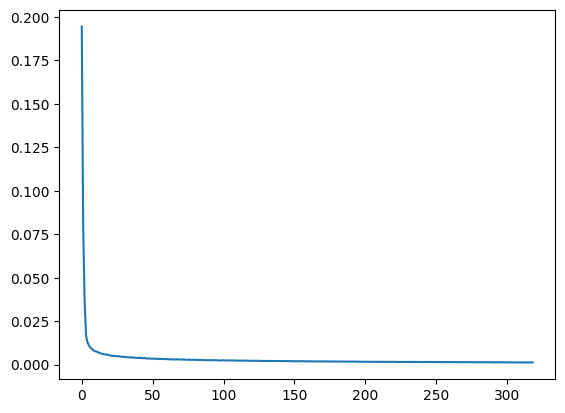

In [29]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
divisions = 10000
x = tf.linspace(-5,5,divisions)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                               min_delta = 0.001,
                               patience=150, 
                               restore_best_weights=True,
                               mode = "auto",
                               verbose = 0,
                               baseline = None)
history = model.fit(x, 
                    epochs = 1000, 
                    verbose = 1, 
                    callbacks=[
                        # WandbMetricsLogger(log_freq=25),
                        # WandbModelCheckpoint("models/model.keras"),
                        early_stopping
                    ])
run.finish()
plt.plot(history.history["loss"])

## Visualizamos

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


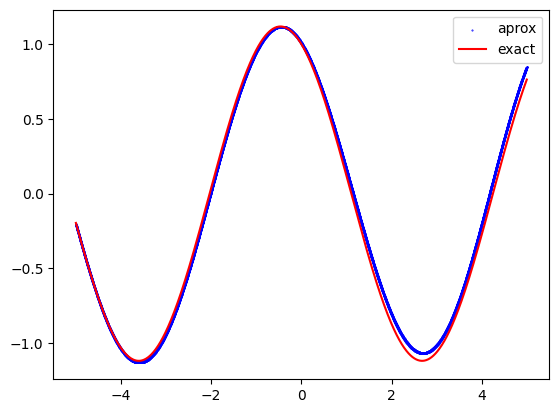

In [31]:
x_testv = tf.linspace(-5,5,divisions)
x = x_testv
a=model.predict(x_testv)
plt.scatter(x_testv,a,label="aprox", s = 0.2, color = "blue")
plt.plot(x_testv, np.cos(x) - 0.5*np.sin(x),label="exact", color = "red")
plt.legend()
plt.show()